In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 128

In [3]:
file_name = 'wheat_21_var_3_species'

In [4]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3

FILT = 1
FILTER = filter_method(FILT).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = 1

#will be used for test dataset in msc
reference= None

In [5]:
def dataset_file_name(file_name):
    name = "./dataset/"+str(file_name)
    if FILT != 0:
        name+="_FILTER_"+str(FILTER)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)+"_DERIVATIVE_"+str(DERIVATIVE)
    return name

In [6]:
DATASET_FILE_NAME = dataset_file_name(file_name)
X_train_file = DATASET_FILE_NAME+"_train_dataset.npy"
y_train_file = DATASET_FILE_NAME+"_train_dataset_label.npy"
X_test_file = DATASET_FILE_NAME+"_test_dataset.npy"
y_test_file = DATASET_FILE_NAME+"_test_dataset_label.npy"

In [7]:
X_train =  np.load(X_train_file)
y_train =  np.load(y_train_file)
X_test  =  np.load(X_test_file)
y_test  =  np.load(y_test_file)

In [8]:
y_set = set(y_train)

In [9]:
NUM_OF_CLASSES = len(y_set)

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape)

(33868, 147, 1)
(8468, 147, 1)


In [11]:
import keras
from keras import Sequential
from keras.layers import Input, Conv1D, Flatten, Dense, MaxPooling1D, Dropout

In [12]:
def createModel(input_shape,num_classes):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, input_shape=input_shape,activation='LeakyReLU'))
    model.add(MaxPooling1D(pool_size=5 ))
    model.add(Conv1D(filters=64, kernel_size=5, activation='LeakyReLU'))
    model.add(MaxPooling1D(pool_size=5 ))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(800, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(400, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    
    return model

In [13]:
model = createModel(X_train.shape[1:],NUM_OF_CLASSES)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 143, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 28, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0

In [15]:
train_eva = []
test_eva = []

In [16]:
history_dataframe = pd.DataFrame() 

In [17]:
for x in range(400):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True, validation_split = 0.25)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))


Epoch:  1
199/199 - 12s - loss: 1.0894 - accuracy: 0.3750 - val_loss: 1.0417 - val_accuracy: 0.4721 - 12s/epoch - 63ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 1.0395 - accuracy: 0.4731
for testing
265/265 [==============================] - 1s 5ms/step - loss: 1.0465 - accuracy: 0.4708

Epoch:  2
199/199 - 8s - loss: 1.0105 - accuracy: 0.4867 - val_loss: 0.9867 - val_accuracy: 0.4938 - 8s/epoch - 38ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.9819 - accuracy: 0.4990
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.9882 - accuracy: 0.4909

Epoch:  3
199/199 - 7s - loss: 0.9181 - accuracy: 0.5647 - val_loss: 0.7963 - val_accuracy: 0.6353 - 7s/epoch - 38ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.7901 - accuracy: 0.6436
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.8027 - accuracy: 0.6336

Epoch:  4
199

265/265 [==============================] - 1s 5ms/step - loss: 0.2377 - accuracy: 0.9040

Epoch:  26
199/199 - 8s - loss: 0.2879 - accuracy: 0.8784 - val_loss: 0.2550 - val_accuracy: 0.8765 - 8s/epoch - 41ms/step
for training
1059/1059 [==============================] - 6s 5ms/step - loss: 0.2472 - accuracy: 0.8827
for testing
265/265 [==============================] - 1s 5ms/step - loss: 0.2580 - accuracy: 0.8784

Epoch:  27
199/199 - 8s - loss: 0.2909 - accuracy: 0.8771 - val_loss: 0.2255 - val_accuracy: 0.9138 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 5ms/step - loss: 0.2199 - accuracy: 0.9162
for testing
265/265 [==============================] - 1s 5ms/step - loss: 0.2298 - accuracy: 0.9147

Epoch:  28
199/199 - 8s - loss: 0.2961 - accuracy: 0.8748 - val_loss: 0.2050 - val_accuracy: 0.9190 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.1960 - accuracy: 0.9242
for testing
265/265 [====

1059/1059 [==============================] - 6s 6ms/step - loss: 0.1158 - accuracy: 0.9590
for testing
265/265 [==============================] - 1s 5ms/step - loss: 0.1253 - accuracy: 0.9549

Epoch:  51
199/199 - 8s - loss: 0.1847 - accuracy: 0.9247 - val_loss: 0.1227 - val_accuracy: 0.9563 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 5ms/step - loss: 0.1134 - accuracy: 0.9592
for testing
265/265 [==============================] - 1s 5ms/step - loss: 0.1206 - accuracy: 0.9564

Epoch:  52
199/199 - 8s - loss: 0.1848 - accuracy: 0.9260 - val_loss: 0.1184 - val_accuracy: 0.9563 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.1100 - accuracy: 0.9595
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.1213 - accuracy: 0.9556

Epoch:  53
199/199 - 8s - loss: 0.1888 - accuracy: 0.9241 - val_loss: 0.1214 - val_accuracy: 0.9558 - 8s/epoch - 39ms/step
for training
1059/1059 [==

for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0733 - accuracy: 0.9758
for testing
265/265 [==============================] - 1s 5ms/step - loss: 0.0806 - accuracy: 0.9728

Epoch:  76
199/199 - 8s - loss: 0.1469 - accuracy: 0.9418 - val_loss: 0.1014 - val_accuracy: 0.9643 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 5ms/step - loss: 0.0917 - accuracy: 0.9674
for testing
265/265 [==============================] - 1s 5ms/step - loss: 0.1013 - accuracy: 0.9647

Epoch:  77
199/199 - 8s - loss: 0.1455 - accuracy: 0.9424 - val_loss: 0.0858 - val_accuracy: 0.9702 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0784 - accuracy: 0.9730
for testing
265/265 [==============================] - 1s 5ms/step - loss: 0.0882 - accuracy: 0.9699

Epoch:  78
199/199 - 8s - loss: 0.1408 - accuracy: 0.9437 - val_loss: 0.0757 - val_accuracy: 0.9748 - 8s/epoch - 39ms/step
for training


for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0710 - accuracy: 0.9755
for testing
265/265 [==============================] - 1s 6ms/step - loss: 0.0757 - accuracy: 0.9737

Epoch:  101
199/199 - 8s - loss: 0.1263 - accuracy: 0.9517 - val_loss: 0.0663 - val_accuracy: 0.9791 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0578 - accuracy: 0.9822
for testing
265/265 [==============================] - 1s 5ms/step - loss: 0.0655 - accuracy: 0.9812

Epoch:  102
199/199 - 8s - loss: 0.1185 - accuracy: 0.9537 - val_loss: 0.0657 - val_accuracy: 0.9783 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 5ms/step - loss: 0.0536 - accuracy: 0.9819
for testing
265/265 [==============================] - 1s 5ms/step - loss: 0.0654 - accuracy: 0.9778

Epoch:  103
199/199 - 8s - loss: 0.1169 - accuracy: 0.9556 - val_loss: 0.0708 - val_accuracy: 0.9764 - 8s/epoch - 39ms/step
for traini

for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0505 - accuracy: 0.9829
for testing
265/265 [==============================] - 1s 5ms/step - loss: 0.0612 - accuracy: 0.9786

Epoch:  126
199/199 - 8s - loss: 0.0981 - accuracy: 0.9622 - val_loss: 0.0582 - val_accuracy: 0.9798 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0465 - accuracy: 0.9839
for testing
265/265 [==============================] - 2s 8ms/step - loss: 0.0558 - accuracy: 0.9824

Epoch:  127
199/199 - 8s - loss: 0.1034 - accuracy: 0.9600 - val_loss: 0.0567 - val_accuracy: 0.9817 - 8s/epoch - 42ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0453 - accuracy: 0.9854
for testing
265/265 [==============================] - 1s 6ms/step - loss: 0.0543 - accuracy: 0.9823

Epoch:  128
199/199 - 8s - loss: 0.0992 - accuracy: 0.9630 - val_loss: 0.0575 - val_accuracy: 0.9803 - 8s/epoch - 39ms/step
for traini

for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0475 - accuracy: 0.9839
for testing
265/265 [==============================] - 1s 6ms/step - loss: 0.0573 - accuracy: 0.9810

Epoch:  151
199/199 - 8s - loss: 0.0845 - accuracy: 0.9680 - val_loss: 0.0499 - val_accuracy: 0.9832 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0383 - accuracy: 0.9872
for testing
265/265 [==============================] - 1s 5ms/step - loss: 0.0478 - accuracy: 0.9835

Epoch:  152
199/199 - 8s - loss: 0.0874 - accuracy: 0.9672 - val_loss: 0.0529 - val_accuracy: 0.9823 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0403 - accuracy: 0.9875
for testing
265/265 [==============================] - 1s 6ms/step - loss: 0.0491 - accuracy: 0.9849

Epoch:  153
199/199 - 8s - loss: 0.0881 - accuracy: 0.9666 - val_loss: 0.0643 - val_accuracy: 0.9777 - 8s/epoch - 39ms/step
for traini

for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0272 - accuracy: 0.9906
for testing
265/265 [==============================] - 1s 6ms/step - loss: 0.0334 - accuracy: 0.9888

Epoch:  176
199/199 - 8s - loss: 0.0795 - accuracy: 0.9706 - val_loss: 0.0424 - val_accuracy: 0.9856 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0300 - accuracy: 0.9904
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0392 - accuracy: 0.9883

Epoch:  177
199/199 - 8s - loss: 0.0753 - accuracy: 0.9710 - val_loss: 0.0452 - val_accuracy: 0.9854 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0347 - accuracy: 0.9883
for testing
265/265 [==============================] - 1s 6ms/step - loss: 0.0436 - accuracy: 0.9850

Epoch:  178
199/199 - 8s - loss: 0.0745 - accuracy: 0.9720 - val_loss: 0.0378 - val_accuracy: 0.9870 - 8s/epoch - 39ms/step
for traini

for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0291 - accuracy: 0.9907
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0381 - accuracy: 0.9883

Epoch:  201
199/199 - 8s - loss: 0.0682 - accuracy: 0.9754 - val_loss: 0.0500 - val_accuracy: 0.9824 - 8s/epoch - 40ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0361 - accuracy: 0.9875
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0483 - accuracy: 0.9818

Epoch:  202
199/199 - 8s - loss: 0.0752 - accuracy: 0.9718 - val_loss: 0.0381 - val_accuracy: 0.9876 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0241 - accuracy: 0.9928
for testing
265/265 [==============================] - 1s 5ms/step - loss: 0.0345 - accuracy: 0.9890

Epoch:  203
199/199 - 8s - loss: 0.0702 - accuracy: 0.9741 - val_loss: 0.0353 - val_accuracy: 0.9880 - 8s/epoch - 39ms/step
for traini

for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0214 - accuracy: 0.9938
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0308 - accuracy: 0.9911

Epoch:  226
199/199 - 8s - loss: 0.0664 - accuracy: 0.9756 - val_loss: 0.0377 - val_accuracy: 0.9880 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0238 - accuracy: 0.9929
for testing
265/265 [==============================] - 1s 5ms/step - loss: 0.0358 - accuracy: 0.9890

Epoch:  227
199/199 - 8s - loss: 0.0668 - accuracy: 0.9750 - val_loss: 0.0373 - val_accuracy: 0.9869 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0240 - accuracy: 0.9922
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0372 - accuracy: 0.9882

Epoch:  228
199/199 - 8s - loss: 0.0679 - accuracy: 0.9757 - val_loss: 0.0392 - val_accuracy: 0.9865 - 8s/epoch - 39ms/step
for traini

for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0220 - accuracy: 0.9931
for testing
265/265 [==============================] - 1s 5ms/step - loss: 0.0335 - accuracy: 0.9885

Epoch:  251
199/199 - 8s - loss: 0.0581 - accuracy: 0.9786 - val_loss: 0.0391 - val_accuracy: 0.9876 - 8s/epoch - 40ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0247 - accuracy: 0.9922
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0313 - accuracy: 0.9891

Epoch:  252
199/199 - 8s - loss: 0.0611 - accuracy: 0.9764 - val_loss: 0.0383 - val_accuracy: 0.9864 - 8s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0258 - accuracy: 0.9913
for testing
265/265 [==============================] - 1s 5ms/step - loss: 0.0376 - accuracy: 0.9869

Epoch:  253
199/199 - 8s - loss: 0.0596 - accuracy: 0.9780 - val_loss: 0.0423 - val_accuracy: 0.9869 - 8s/epoch - 40ms/step
for traini

for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0232 - accuracy: 0.9925
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0357 - accuracy: 0.9871

Epoch:  276
199/199 - 8s - loss: 0.0569 - accuracy: 0.9794 - val_loss: 0.0410 - val_accuracy: 0.9863 - 8s/epoch - 40ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0253 - accuracy: 0.9916
for testing
265/265 [==============================] - 1s 6ms/step - loss: 0.0395 - accuracy: 0.9868

Epoch:  277
199/199 - 8s - loss: 0.0624 - accuracy: 0.9787 - val_loss: 0.0362 - val_accuracy: 0.9876 - 8s/epoch - 41ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0247 - accuracy: 0.9929
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0346 - accuracy: 0.9895

Epoch:  278
199/199 - 8s - loss: 0.0547 - accuracy: 0.9791 - val_loss: 0.0419 - val_accuracy: 0.9859 - 8s/epoch - 40ms/step
for traini

for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0141 - accuracy: 0.9959
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0257 - accuracy: 0.9915

Epoch:  301
199/199 - 8s - loss: 0.0500 - accuracy: 0.9821 - val_loss: 0.0287 - val_accuracy: 0.9902 - 8s/epoch - 40ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0146 - accuracy: 0.9957
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0276 - accuracy: 0.9917

Epoch:  302
199/199 - 8s - loss: 0.0506 - accuracy: 0.9811 - val_loss: 0.0332 - val_accuracy: 0.9890 - 8s/epoch - 40ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0183 - accuracy: 0.9945
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0285 - accuracy: 0.9909

Epoch:  303
199/199 - 8s - loss: 0.0499 - accuracy: 0.9822 - val_loss: 0.0285 - val_accuracy: 0.9894 - 8s/epoch - 40ms/step
for traini

for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0167 - accuracy: 0.9950
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0334 - accuracy: 0.9915

Epoch:  326
199/199 - 8s - loss: 0.0532 - accuracy: 0.9805 - val_loss: 0.0313 - val_accuracy: 0.9878 - 8s/epoch - 40ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0180 - accuracy: 0.9941
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0324 - accuracy: 0.9907

Epoch:  327
199/199 - 8s - loss: 0.0551 - accuracy: 0.9800 - val_loss: 0.0275 - val_accuracy: 0.9911 - 8s/epoch - 40ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0141 - accuracy: 0.9960
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0283 - accuracy: 0.9907

Epoch:  328
199/199 - 8s - loss: 0.0537 - accuracy: 0.9795 - val_loss: 0.0399 - val_accuracy: 0.9875 - 8s/epoch - 40ms/step
for traini

for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0154 - accuracy: 0.9956
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0270 - accuracy: 0.9917

Epoch:  351
199/199 - 8s - loss: 0.0480 - accuracy: 0.9823 - val_loss: 0.0283 - val_accuracy: 0.9891 - 8s/epoch - 41ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0139 - accuracy: 0.9952
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0299 - accuracy: 0.9900

Epoch:  352
199/199 - 8s - loss: 0.0427 - accuracy: 0.9847 - val_loss: 0.0264 - val_accuracy: 0.9906 - 8s/epoch - 42ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0118 - accuracy: 0.9965
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0254 - accuracy: 0.9921

Epoch:  353
199/199 - 8s - loss: 0.0463 - accuracy: 0.9821 - val_loss: 0.0293 - val_accuracy: 0.9893 - 8s/epoch - 41ms/step
for traini

for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0140 - accuracy: 0.9961
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0286 - accuracy: 0.9910

Epoch:  376
199/199 - 8s - loss: 0.0431 - accuracy: 0.9848 - val_loss: 0.0380 - val_accuracy: 0.9871 - 8s/epoch - 41ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0235 - accuracy: 0.9917
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0374 - accuracy: 0.9862

Epoch:  377
199/199 - 9s - loss: 0.0421 - accuracy: 0.9843 - val_loss: 0.0381 - val_accuracy: 0.9875 - 9s/epoch - 45ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0194 - accuracy: 0.9937
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0367 - accuracy: 0.9885

Epoch:  378
199/199 - 8s - loss: 0.0498 - accuracy: 0.9820 - val_loss: 0.0301 - val_accuracy: 0.9902 - 8s/epoch - 41ms/step
for traini

for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0165 - accuracy: 0.9948
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0321 - accuracy: 0.9894


In [18]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

In [19]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

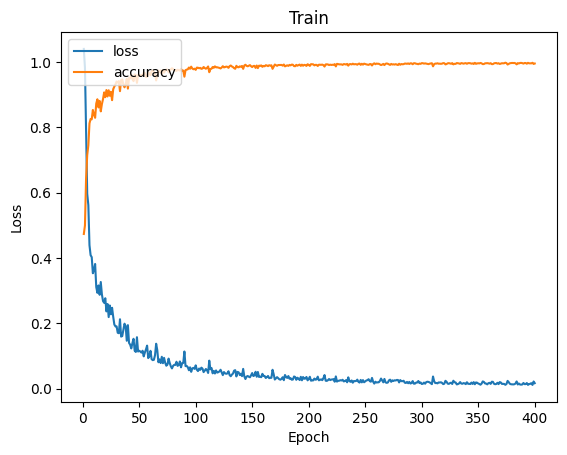

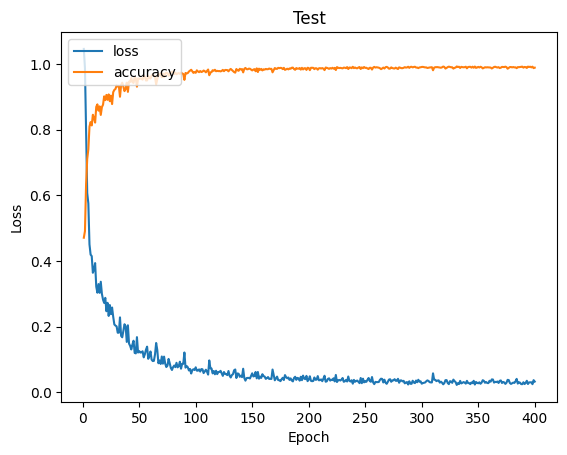

In [20]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])

In [21]:
train_eva_df['accuracy'].max()

0.9973426461219788

In [22]:
train_eva_df.idxmax()

loss          0
accuracy    373
dtype: int64

In [23]:
test_eva_df['accuracy'].max()

0.9930325746536255

In [24]:
test_eva_df.idxmax()

loss          0
accuracy    330
dtype: int64

In [25]:
for x in range(400,600):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))


Epoch:  401
265/265 - 10s - loss: 0.0546 - accuracy: 0.9806 - 10s/epoch - 37ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0155 - accuracy: 0.9954
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0287 - accuracy: 0.9911

Epoch:  402
265/265 - 10s - loss: 0.0456 - accuracy: 0.9836 - 10s/epoch - 38ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0142 - accuracy: 0.9956
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0278 - accuracy: 0.9913

Epoch:  403
265/265 - 10s - loss: 0.0550 - accuracy: 0.9810 - 10s/epoch - 38ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0171 - accuracy: 0.9950
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0294 - accuracy: 0.9895

Epoch:  404
265/265 - 10s - loss: 0.0479 - accuracy: 0.9828 - 10s/epoch - 38ms/step
for training
1059/1059 [=====================

for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0098 - accuracy: 0.9972
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0237 - accuracy: 0.9921

Epoch:  430
265/265 - 10s - loss: 0.0525 - accuracy: 0.9816 - 10s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0094 - accuracy: 0.9973
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0233 - accuracy: 0.9926

Epoch:  431
265/265 - 10s - loss: 0.0440 - accuracy: 0.9840 - 10s/epoch - 38ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0197 - accuracy: 0.9929
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0372 - accuracy: 0.9872

Epoch:  432
265/265 - 10s - loss: 0.0455 - accuracy: 0.9831 - 10s/epoch - 39ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0118 - accuracy: 0.9960
for testing
265/265 [=====

1059/1059 [==============================] - 7s 6ms/step - loss: 0.0118 - accuracy: 0.9964
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0297 - accuracy: 0.9906

Epoch:  458
265/265 - 11s - loss: 0.0438 - accuracy: 0.9840 - 11s/epoch - 41ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0127 - accuracy: 0.9958
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0276 - accuracy: 0.9911

Epoch:  459
265/265 - 11s - loss: 0.0442 - accuracy: 0.9843 - 11s/epoch - 41ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0076 - accuracy: 0.9985
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0235 - accuracy: 0.9932

Epoch:  460
265/265 - 10s - loss: 0.0382 - accuracy: 0.9859 - 10s/epoch - 39ms/step
for training
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0066 - accuracy: 0.9985
for testing
265/265 [==================

1059/1059 [==============================] - 7s 6ms/step - loss: 0.0060 - accuracy: 0.9986
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0253 - accuracy: 0.9932

Epoch:  486
265/265 - 11s - loss: 0.0397 - accuracy: 0.9853 - 11s/epoch - 40ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0065 - accuracy: 0.9986
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0230 - accuracy: 0.9926

Epoch:  487
265/265 - 10s - loss: 0.0405 - accuracy: 0.9850 - 10s/epoch - 39ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0081 - accuracy: 0.9979
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0253 - accuracy: 0.9921

Epoch:  488
265/265 - 10s - loss: 0.0448 - accuracy: 0.9842 - 10s/epoch - 39ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0064 - accuracy: 0.9987
for testing
265/265 [==================

1059/1059 [==============================] - 7s 6ms/step - loss: 0.0071 - accuracy: 0.9980
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0222 - accuracy: 0.9934

Epoch:  514
265/265 - 10s - loss: 0.0348 - accuracy: 0.9874 - 10s/epoch - 39ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0047 - accuracy: 0.9992
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0196 - accuracy: 0.9933

Epoch:  515
265/265 - 10s - loss: 0.0374 - accuracy: 0.9861 - 10s/epoch - 39ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0058 - accuracy: 0.9986
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0193 - accuracy: 0.9932

Epoch:  516
265/265 - 10s - loss: 0.0387 - accuracy: 0.9865 - 10s/epoch - 39ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0051 - accuracy: 0.9988
for testing
265/265 [==================

1059/1059 [==============================] - 7s 6ms/step - loss: 0.0076 - accuracy: 0.9979
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0253 - accuracy: 0.9927

Epoch:  542
265/265 - 11s - loss: 0.0319 - accuracy: 0.9886 - 11s/epoch - 40ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0041 - accuracy: 0.9993
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0204 - accuracy: 0.9941

Epoch:  543
265/265 - 10s - loss: 0.0342 - accuracy: 0.9876 - 10s/epoch - 39ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0066 - accuracy: 0.9984
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0297 - accuracy: 0.9924

Epoch:  544
265/265 - 10s - loss: 0.0403 - accuracy: 0.9858 - 10s/epoch - 39ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0064 - accuracy: 0.9990
for testing
265/265 [==================

1059/1059 [==============================] - 7s 6ms/step - loss: 0.0038 - accuracy: 0.9993
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0243 - accuracy: 0.9929

Epoch:  570
265/265 - 11s - loss: 0.0344 - accuracy: 0.9877 - 11s/epoch - 40ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0049 - accuracy: 0.9991
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0236 - accuracy: 0.9936

Epoch:  571
265/265 - 11s - loss: 0.0313 - accuracy: 0.9882 - 11s/epoch - 40ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0062 - accuracy: 0.9982
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0296 - accuracy: 0.9917

Epoch:  572
265/265 - 11s - loss: 0.0336 - accuracy: 0.9882 - 11s/epoch - 40ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0049 - accuracy: 0.9989
for testing
265/265 [==================

1059/1059 [==============================] - 7s 6ms/step - loss: 0.0064 - accuracy: 0.9982
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0292 - accuracy: 0.9900

Epoch:  598
265/265 - 11s - loss: 0.0344 - accuracy: 0.9878 - 11s/epoch - 40ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0053 - accuracy: 0.9988
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0207 - accuracy: 0.9936

Epoch:  599
265/265 - 11s - loss: 0.0336 - accuracy: 0.9883 - 11s/epoch - 40ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0047 - accuracy: 0.9995
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0211 - accuracy: 0.9937

Epoch:  600
265/265 - 11s - loss: 0.0300 - accuracy: 0.9892 - 11s/epoch - 40ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0081 - accuracy: 0.9978
for testing
265/265 [==================

In [26]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

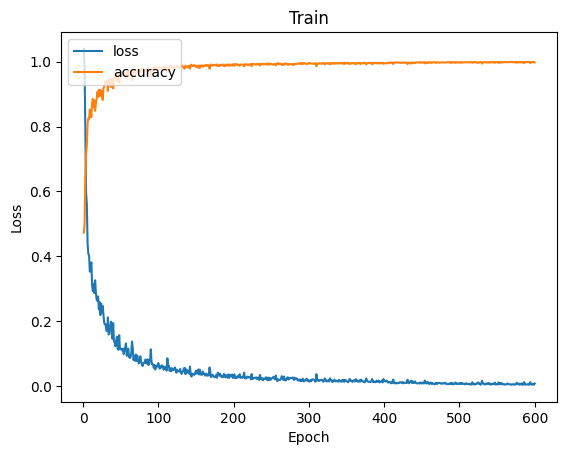

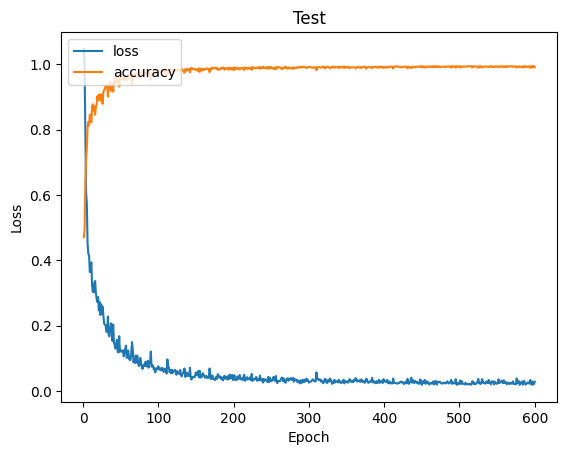

In [27]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])

In [28]:
train_eva_df['accuracy'].max()

0.9994980692863464

In [29]:
train_eva_df.idxmax()

loss          0
accuracy    595
dtype: int64

In [30]:
test_eva_df['accuracy'].max()

0.9945678114891052

In [31]:
test_eva_df.idxmax()

loss          0
accuracy    465
dtype: int64

### Its not 401 to 600, its 601 to 800

In [32]:
for x in range(400,600):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))


Epoch:  401
265/265 - 11s - loss: 0.0344 - accuracy: 0.9879 - 11s/epoch - 42ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0070 - accuracy: 0.9987
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0245 - accuracy: 0.9920

Epoch:  402
265/265 - 11s - loss: 0.0318 - accuracy: 0.9880 - 11s/epoch - 43ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0038 - accuracy: 0.9993
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0213 - accuracy: 0.9926

Epoch:  403
265/265 - 11s - loss: 0.0395 - accuracy: 0.9865 - 11s/epoch - 42ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0093 - accuracy: 0.9973
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0293 - accuracy: 0.9901

Epoch:  404
265/265 - 11s - loss: 0.0311 - accuracy: 0.9889 - 11s/epoch - 43ms/step
for training
1059/1059 [=====================

for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0070 - accuracy: 0.9985
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0262 - accuracy: 0.9926

Epoch:  430
265/265 - 11s - loss: 0.0325 - accuracy: 0.9888 - 11s/epoch - 40ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0052 - accuracy: 0.9985
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0247 - accuracy: 0.9927

Epoch:  431
265/265 - 11s - loss: 0.0310 - accuracy: 0.9885 - 11s/epoch - 41ms/step
for training
1059/1059 [==============================] - 8s 7ms/step - loss: 0.0096 - accuracy: 0.9972
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0349 - accuracy: 0.9900

Epoch:  432
265/265 - 12s - loss: 0.0298 - accuracy: 0.9891 - 12s/epoch - 43ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0030 - accuracy: 0.9994
for testing
265/265 [=====

1059/1059 [==============================] - 8s 7ms/step - loss: 0.0042 - accuracy: 0.9993
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0237 - accuracy: 0.9934

Epoch:  458
265/265 - 11s - loss: 0.0282 - accuracy: 0.9894 - 11s/epoch - 41ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0038 - accuracy: 0.9992
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0257 - accuracy: 0.9928

Epoch:  459
265/265 - 11s - loss: 0.0329 - accuracy: 0.9883 - 11s/epoch - 41ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0036 - accuracy: 0.9994
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0212 - accuracy: 0.9936

Epoch:  460
265/265 - 11s - loss: 0.0307 - accuracy: 0.9895 - 11s/epoch - 41ms/step
for training
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0073 - accuracy: 0.9982
for testing
265/265 [==================

1059/1059 [==============================] - 7s 7ms/step - loss: 0.0034 - accuracy: 0.9995
for testing
265/265 [==============================] - 2s 6ms/step - loss: 0.0197 - accuracy: 0.9941

Epoch:  486
265/265 - 11s - loss: 0.0276 - accuracy: 0.9903 - 11s/epoch - 41ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0042 - accuracy: 0.9991
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0259 - accuracy: 0.9923

Epoch:  487
265/265 - 11s - loss: 0.0304 - accuracy: 0.9895 - 11s/epoch - 41ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0066 - accuracy: 0.9983
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0262 - accuracy: 0.9916

Epoch:  488
265/265 - 11s - loss: 0.0349 - accuracy: 0.9873 - 11s/epoch - 41ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0061 - accuracy: 0.9989
for testing
265/265 [==================

1059/1059 [==============================] - 7s 7ms/step - loss: 0.0054 - accuracy: 0.9985
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0248 - accuracy: 0.9916

Epoch:  514
265/265 - 11s - loss: 0.0279 - accuracy: 0.9900 - 11s/epoch - 42ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0033 - accuracy: 0.9995
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0208 - accuracy: 0.9943

Epoch:  515
265/265 - 11s - loss: 0.0312 - accuracy: 0.9887 - 11s/epoch - 43ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0039 - accuracy: 0.9994
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0185 - accuracy: 0.9934

Epoch:  516
265/265 - 11s - loss: 0.0283 - accuracy: 0.9900 - 11s/epoch - 41ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0036 - accuracy: 0.9993
for testing
265/265 [==================

1059/1059 [==============================] - 7s 7ms/step - loss: 0.0025 - accuracy: 0.9996
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0282 - accuracy: 0.9940

Epoch:  542
265/265 - 11s - loss: 0.0465 - accuracy: 0.9850 - 11s/epoch - 42ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0027 - accuracy: 0.9998
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0206 - accuracy: 0.9946

Epoch:  543
265/265 - 11s - loss: 0.0733 - accuracy: 0.9823 - 11s/epoch - 42ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0045 - accuracy: 0.9988
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0220 - accuracy: 0.9932

Epoch:  544
265/265 - 11s - loss: 0.0265 - accuracy: 0.9906 - 11s/epoch - 42ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0029 - accuracy: 0.9995
for testing
265/265 [==================

1059/1059 [==============================] - 7s 7ms/step - loss: 0.0061 - accuracy: 0.9981
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0290 - accuracy: 0.9914

Epoch:  570
265/265 - 11s - loss: 0.0239 - accuracy: 0.9916 - 11s/epoch - 43ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0030 - accuracy: 0.9993
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0282 - accuracy: 0.9941

Epoch:  571
265/265 - 11s - loss: 0.0279 - accuracy: 0.9901 - 11s/epoch - 43ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0025 - accuracy: 0.9997
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0227 - accuracy: 0.9935

Epoch:  572
265/265 - 11s - loss: 0.0285 - accuracy: 0.9901 - 11s/epoch - 43ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0033 - accuracy: 0.9996
for testing
265/265 [==================

1059/1059 [==============================] - 7s 7ms/step - loss: 0.0035 - accuracy: 0.9993
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0273 - accuracy: 0.9929

Epoch:  598
265/265 - 11s - loss: 0.0224 - accuracy: 0.9919 - 11s/epoch - 43ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0027 - accuracy: 0.9994
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0220 - accuracy: 0.9936

Epoch:  599
265/265 - 11s - loss: 0.0303 - accuracy: 0.9896 - 11s/epoch - 43ms/step
for training
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0031 - accuracy: 0.9997
for testing
265/265 [==============================] - 2s 7ms/step - loss: 0.0222 - accuracy: 0.9937

Epoch:  600
265/265 - 11s - loss: 0.0267 - accuracy: 0.9906 - 11s/epoch - 43ms/step
for training
1059/1059 [==============================] - 8s 7ms/step - loss: 0.0023 - accuracy: 0.9996
for testing
265/265 [==================

In [33]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

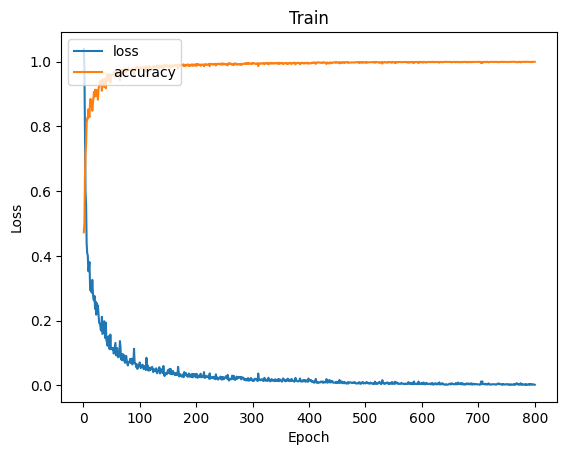

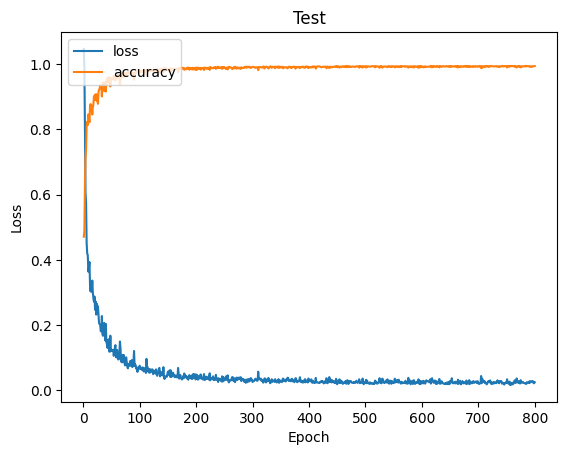

In [34]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])

In [35]:
train_eva_df['accuracy'].max()

0.999793291091919

In [36]:
train_eva_df.idxmax()

loss          0
accuracy    741
dtype: int64

In [37]:
test_eva_df['accuracy'].max()

0.9946858882904053

In [38]:
test_eva_df.idxmax()

loss          0
accuracy    615
dtype: int64